# import

In [1]:
#!pip install catboost

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
import shap
from scipy.interpolate import interp1d
shap.initjs()

/Users/erikapat/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/erikapat/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict


# Data Prep

Titanic data.

In [3]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [4]:
train_data.shape, test_data.shape

((891, 12), (418, 11))

In [5]:
X_all=pd.concat([train_data[['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']],
                 test_data[['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
                ]).set_index('PassengerId')
y_train=train_data[['PassengerId','Survived']].set_index('PassengerId')['Survived']

In [6]:
X_all.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S


In [7]:
num_columns=['Age','SibSp','Parch','Fare']
cat_columns=list(filter(lambda x:x not in num_columns,X_all.columns))

In [8]:
# categorical features: finn nan's with string
X_all[cat_columns]=X_all[cat_columns].astype(str)
X_all[cat_columns]=X_all[cat_columns].fillna('NAN')

In [9]:
# data for catboost
X_train=X_all.iloc[:len(train_data),:]
X_test=X_all.iloc[len(train_data):]

In [10]:
# data for logreg
X_train_lor=X_train.copy()
for col in num_columns:
    X_train_lor[col]=X_train_lor[col].fillna(X_train_lor[col].median())
X_train_lor=pd.get_dummies(X_train_lor)

In [11]:
X_trn, X_val, y_trn, y_val = train_test_split(X_train, 
                                              y_train, 
                                              test_size=.2, 
                                              random_state=4321)
X_trn_lor = X_train_lor.loc[X_trn.index,:]
X_val_lor = X_train_lor.loc[X_val.index,:]

# Logistic Regression

An increment of 1 unit in xⱼ the odds will increase by a factor of exp(βⱼ).
![alt text](fig/log_eq.png "Title") 

In [12]:
lor = LogisticRegression(random_state=0, solver='lbfgs',max_iter=500).fit(X_trn_lor,y_trn)

In [13]:
print('accuracy:',accuracy_score(y_val,lor.predict(X_val_lor)))

accuracy: 0.8156424581005587


In [14]:
lor_coef = pd.Series(lor.coef_[0], index = X_trn_lor.columns)
lor_coef = pd.DataFrame({'exp(β)':lor_coef.apply(lambda x:np.exp(x))}).round(3)
lor_coef.style.apply(lambda x: ["background:orangered" if v<1 else "background:lightgreen"
                                for v in x], axis = 1)

,exp(β)
Age,0.961
SibSp,0.692
Parch,0.912
Fare,1.003
Pclass_1,2.553
Pclass_2,0.99
Pclass_3,0.396
Sex_female,3.676
Sex_male,0.272
Embarked_C,1.316


# Catboost

Without any hyperparametrization.

In [15]:
cat_features=[X_trn.columns.to_list().index(col) for col in cat_columns]
cat = CatBoostClassifier(cat_features=cat_features,silent=True).fit(X_trn,y_trn)
probas_cat = pd.Series(cat.predict_proba(X_all)[:,1],index=X_all.index)

In [16]:
print('accuracy:',accuracy_score(y_val,cat.predict(X_val)))

accuracy: 0.8603351955307262


# Fuctions

In [17]:
def shap2deltaprob(features, 
                   shap_df, 
                   shap_sum,
                   probas,
                   func_shap2probas):
    '''
    map shap to Δ probabilities
    --- input ---
    :features: list of strings, names of features
    :shap_df: pd.DataFrame, dataframe containing shap values
    :shap_sum: pd.Series, series containing shap sum for each observation
    :probas: pd.Series, series containing predicted probability for each observation
    :func_shap2probas: function, maps shap to probability (for example interpolation function)
    --- output ---
    :out: pd.Series or pd.DataFrame, Δ probability for each shap value
    '''
    # 1 feature
    if type(features) == str or len(features) == 1:
        return probas - (shap_sum - shap_df[features]).apply(func_shap2probas)
    # more than 1 feature
    else:
        return shap_df[features].apply(lambda x: shap_sum - x).apply(func_shap2probas)\
                .apply(lambda x: probas - x)

In [18]:
def partial_deltaprob(feature, X, shap_df, shap_sum, probas, func_shap2probas,
                      cutoffs = None
                     ):
    '''
    return univariate analysis (count, mean and standard deviation) of shap values based on the original feature
    --- input ---
    :feature: str, name of feature
    :X: pd.Dataframe, shape (N, P)
    :shap_df: pd.DataFrame, shape (N, P)
    :shap_sum: pd.Series, series containing shap sum for each observation
    :probas: pd.Series, series containing predicted probability for each observation
    :func_shap2probas: function, maps shap to probability (for example interpolation function)
    :cutoffs: list of floats, cutoffs for numerical features
    --- output ---
    :out: pd.DataFrame, shape (n_levels, 3)
    '''
    dp_col = shap2deltaprob(feature, shap_df, shap_sum, probas, func_shap2probas)
    dp_col_mean = dp_col.mean()
    dp_col.name = 'DP_' + feature
    out = pd.concat([X[feature], dp_col], axis = 1)
    if cutoffs:
        intervals = pd.IntervalIndex.from_tuples(list(zip(cutoffs[:-1], cutoffs[1:])))
        out[feature] = pd.cut(out[feature], bins = intervals)
        out = out.dropna()   
    out = out.groupby(feature).describe().iloc[:, :3]
    out.columns = ['count', 'mean', 'std']
    out['std'] = out['std'].fillna(0)
    return out

# Shap values on Catboost

ML interpretability is very important to avoid bias. Examples from Google: ["Amazon scraps secret AI recruiting tool that showed bias against women"](https://www.reuters.com/article/us-amazon-com-jobs-automation-insight/amazon-scraps-secret-ai-recruiting-tool-that-showed-bias-against-women-idUSKCN1MK08G) and Microsoft ["Tay: Microsoft issues apology over racist chatbot fiasco"](https://www.bbc.com/news/technology-35902104) certify that.


In [35]:
shap_df = cat.get_feature_importance(data = Pool(X_all, cat_features=cat_features), 
                                  type = 'ShapValues')
shap_df = pd.DataFrame(shap_df[:,:-1], columns = X_all.columns, index = X_all.index)
shap_sum = shap_df.sum(axis = 1)

Feature importance from catboost.

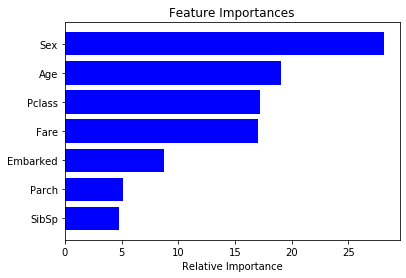

In [38]:
importances = cat.feature_importances_
indices = np.argsort(importances)
features = X_all.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The figure below show the shap values. Moreover, a SHAP value greater than zero leads to an increase in probability, a value less than zero leads to a decrease in probability.

## **Marginal values:**

In [20]:
# show shap
temp = shap_df.head().round(2)
temp.style.apply(lambda x:["background:orangered" if v<0 else "background:lightgreen"
                           for v in x], axis = 1)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,-0.32,-0.77,0.23,0.04,-0.05,-0.29,-0.06
2,1.65,2.37,0.2,0.01,0.08,0.78,0.65
3,-0.82,1.63,0.15,0.14,-0.04,0.18,-0.17
4,1.58,2.16,0.41,-0.07,0.1,0.98,-0.14
5,-0.44,-0.71,-0.01,0.08,-0.03,-0.14,-0.01


In [21]:
# build interpolation function to map shap into probability
shap_sum_sort = shap_sum.sort_values()
probas_cat_sort = probas_cat[shap_sum_sort.index]

intp = interp1d(shap_sum_sort,
                probas_cat_sort, 
                bounds_error = False, 
                fill_value = (0, 1))

## **Percentage Marginal values:**

In [22]:
# show Δ probabilities
temp = shap2deltaprob(X_all.columns.to_list(),
                      shap_df,
                      shap_sum,
                      probas_cat,
                      func_shap2probas=intp).head()\
        .applymap(lambda x:('+'if x>0 else '')+str(round(x*100,2))+'%')

temp.style.apply(lambda x: ["background:orangered" if float(v[:-1])<0 else "background:lightgreen"
                                for v in x], axis = 1)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,-4.27%,-12.01%,+2.52%,+0.46%,-0.56%,-3.91%,-0.76%
2,+2.36%,+5.26%,+0.13%,+0.01%,+0.05%,+0.67%,+0.52%
3,-16.9%,+37.68%,+3.49%,+3.46%,-0.97%,+4.28%,-3.89%
4,+4.29%,+8.19%,+0.59%,-0.08%,+0.12%,+1.92%,-0.15%
5,-6.04%,-10.62%,-0.11%,+0.94%,-0.36%,-1.75%,-0.12%


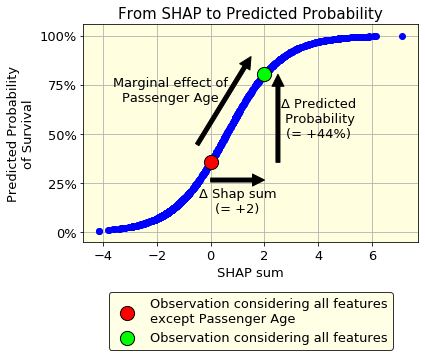

In [23]:
plt.scatter(0,intp(0),s=200,fc='red',ec='black',zorder=3,label='Observation considering all features\nexcept Passenger Age')
plt.scatter(2,intp(2),s=200,fc='lime',ec='black',zorder=3,label='Observation considering all features')

plt.annotate(s='',xy=(2-.5,intp(2)+.5*.18),xytext=(0-.5,intp(0)+.5*.18),arrowprops={'fc':'black'})
plt.text(-1.5,.72,'Marginal effect of\nPassenger Age',ha='center',va='center',fontsize=13)

plt.annotate(s='',xy=(2,intp(0)-.5*.18),xytext=(0,intp(0)-.5*.18),arrowprops={'fc':'black'})
plt.text(1,.23,'Δ Shap sum\n(= +2)',ha='center',va='top',fontsize=13)

plt.annotate(s='',xy=(2+.5,intp(2)),xytext=(2+.5,intp(0)),arrowprops={'fc':'black'})
plt.text(4,(intp(0)+intp(2))/2,'Δ Predicted\n Probability\n(= +44%)',va='center',ha='center',fontsize=13)

legend = plt.legend(bbox_to_anchor=(0.5, -.2), loc = 'upper center',fontsize=13)
frame = legend.get_frame()
frame.set_facecolor('lightyellow')
frame.set_edgecolor('black')

plt.scatter(shap_sum_sort, probas_cat_sort,color='blue',zorder=2)

plt.gca().set_facecolor('lightyellow')
plt.grid(zorder=1)
plt.xlabel('SHAP sum',fontsize=13)
plt.ylabel('Predicted Probability\nof Survival',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks([0,.25,.5,.75,1],['0%','25%','50%','75%','100%'],fontsize=13)
plt.title('From SHAP to Predicted Probability',fontsize=15)

plt.savefig('fig/shap2probability_example.png',bbox_inches='tight',dpi=300)

(Above) Let use take an individual. Suppose that, knowing all the variables except Age, its SHAP sum equals to 0. Now imagine that the SHAP value relative to Age is 2.
It is sufficient for us to know the function f() to quantify the impact of Age on Predicted Probability of survival: it is simply f(2)-f(0). In our case, it is f(2)-f(0) = 80%-36% = 44%
No doubt that probability of survival is more digestible than SHAP of survival. What is more understandable: to say that this individual age leads to a rise of 2 in SHAP or to a rise of 44% in probability?

# Partial plots

In [24]:
# feature importance
pd.Series(cat.feature_importances_, index=cat.feature_names_).sort_values(ascending=False) / sum(cat.feature_importances_)

Sex         0.281278
Age         0.190852
Pclass      0.172183
Fare        0.170066
Embarked    0.087309
Parch       0.050889
SibSp       0.047424
dtype: float64

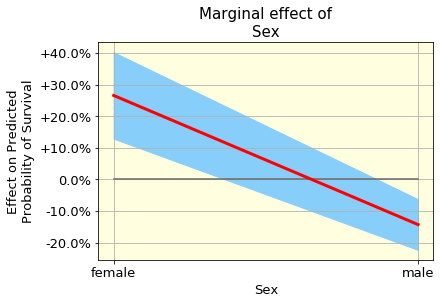

In [25]:
dp = partial_deltaprob('Sex', X_all, shap_df, shap_sum, probas_cat, func_shap2probas=intp)

plt.plot([0,len(dp)-1],[0,0],color='dimgray',zorder=3)
plt.plot(range(len(dp)), dp['mean'], color = 'red', linewidth = 3, label = 'Avg effect',zorder=4)
plt.fill_between(range(len(dp)), dp['mean'] + dp['std'], dp['mean'] - dp['std'],
                 color = 'lightskyblue', label = 'Avg effect +- StDev',zorder=1)
yticks = list(np.arange(-.2,.41,.1))
plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.1%}'.format(y) for y in yticks], fontsize=13)
plt.xticks(range(len(dp)), dp.index, fontsize=13)
plt.ylabel('Effect on Predicted\nProbability of Survival',fontsize=13)
plt.xlabel('Sex', fontsize=13)
plt.title('Marginal effect of\nSex', fontsize=15)
plt.gca().set_facecolor('lightyellow')
plt.grid(zorder=2)

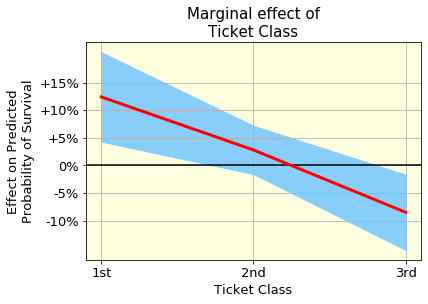

In [26]:
dp = partial_deltaprob('Pclass', X_all, shap_df, shap_sum, probas_cat, func_shap2probas=intp)

plt.axhline(0,color='black',zorder=3)
plt.plot([1,2,3], dp['mean'], color = 'red', linewidth = 3, label = 'Avg effect',zorder=4)
plt.fill_between([1,2,3], dp['mean'] + dp['std'],
                        dp['mean'] - dp['std'],
                        color = 'lightskyblue', label = 'Avg effect +- StDev',zorder=1)
yticks = list(np.arange(-.1,.16,.05))
plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.0%}'.format(y) for y in yticks], fontsize=13)
plt.xticks([1,2,3], ['1st','2nd','3rd'], fontsize=13)
plt.ylabel('Effect on Predicted\nProbability of Survival',fontsize=13)
plt.xlabel('Ticket Class', fontsize=13)
plt.title('Marginal effect of\nTicket Class', fontsize=15)
plt.gca().set_facecolor('lightyellow')
plt.grid(zorder=2)

(Above) For instance, having a 3rd Class ticket reduces the survival probability.

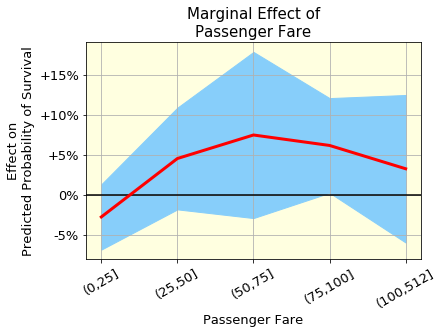

In [27]:
dp = partial_deltaprob('Fare', X_all, shap_df, shap_sum, probas_cat, func_shap2probas=intp, 
                               cutoffs = [0,25,50,75,100,X_train['Fare'].max()])

plt.axhline(0,color='black',zorder=3)
plt.plot(range(len(dp)), dp['mean'], color = 'red', linewidth = 3, label = 'Avg effect',zorder=4)
plt.fill_between(range(len(dp)), dp['mean'] + dp['std'], dp['mean'] - dp['std'],
                 color = 'lightskyblue', label = 'Avg effect +- StDev',zorder=1)
yticks = [-.05,0,.05,.1,.15]
plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.0%}'.format(y) for y in yticks], fontsize=13)
plt.xticks(range(len(dp)), ['(%s,%s]' %(int(x.left),int(x.right)) for x in dp.index.to_list()], fontsize=13,rotation=30)
plt.ylabel('Effect on\nPredicted Probability of Survival',fontsize=13)
plt.xlabel('Passenger Fare', fontsize=13)
plt.title('Marginal Effect of\nPassenger Fare', fontsize=15)
plt.gca().set_facecolor('lightyellow')
plt.grid(zorder=2)

plt.savefig('fig/fare.png',bbox_inches='tight',dpi=300)

(Above) We can visualize non-linear effects. For example, looking at Passenger Fare, the probability of survival increases up to a point and then slightly decreases.

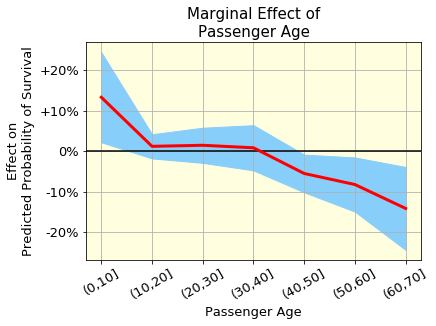

In [28]:
dp = partial_deltaprob('Age', X_all, shap_df, shap_sum, probas_cat, func_shap2probas=intp, cutoffs = list(range(0,75,10)))

plt.axhline(0,color='black',zorder=3)
plt.plot(list(range(7)), dp['mean'], color = 'red', linewidth = 3, label = 'Avg effect',zorder=4)
plt.fill_between(list(range(7)), dp['mean'] + dp['std'],
                        dp['mean'] - dp['std'],
                        color = 'lightskyblue', label = 'Avg effect +- StDev',zorder=1)
yticks = list(np.arange(-.2,.21,.1))
plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.0%}'.format(y) for y in yticks], fontsize=13)
plt.xticks(list(range(7)), ['(%s,%s]' %(int(x.left),int(x.right)) for x in dp.index], fontsize=13,rotation=30)
plt.ylabel('Effect on\nPredicted Probability of Survival',fontsize=13)
plt.xlabel('Passenger Age', fontsize=13)
plt.title('Marginal Effect of\nPassenger Age', fontsize=15)
plt.gca().set_facecolor('lightyellow')
plt.grid(zorder=2)

plt.savefig('fig/age.png',bbox_inches='tight',dpi=300)

(Above) The red line identifies the average effect (mean of Age effect for all individuals in a group), while the blue band (mean ± standard deviation) expresses the variability of Age effect between the individuals in the same group. The variability is due to the interaction between Age and the other variables.

We can quantify effects in terms of probabilities rather than in terms of SHAP values. For instance, we can say that, on average, being 60–70 yo leads to a decrease of 27% in probability of survival compared to being 0–10 yo (from +14% to -13%);

# Interaction plot

In [29]:
temp = pd.DataFrame(shap_df[['Pclass','Fare']].sum(axis=1))
temp.columns = ['deltaprob']
temp = probas_cat - (shap_sum - temp['deltaprob']).apply(intp)
temp = pd.concat([X_all[['Pclass','Fare']],temp],axis=1)
temp['Fare'] = pd.cut(temp['Fare'],[0,25,50,75,100,513])
bi = temp.groupby(['Pclass','Fare']).describe()[0].iloc[:,:3]

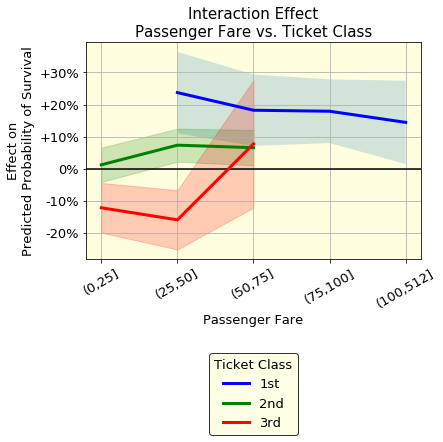

In [30]:
sel = [1,2,3,4]
temp = bi.loc['1',['mean','std']].iloc[sel,:]
plt.plot(sel,temp['mean'],linewidth = 3,label='1st',zorder=4,color='blue')
plt.fill_between(sel, temp['mean'] + temp['std'], temp['mean'] - temp['std'],
                 zorder=1,alpha=.2)

sel = [0,1,2]
temp = bi.loc['2',['mean','std']].iloc[sel,:]
plt.plot(sel,temp['mean'],linewidth = 3,label='2nd',zorder=4,color='green')
plt.fill_between(sel, temp['mean'] + temp['std'], temp['mean'] - temp['std'],
                 zorder=1,color='green',alpha=.2)

sel = [0,1,2]
temp = bi.loc['3',['mean','std']].iloc[sel,:]
plt.plot(sel,temp['mean'],linewidth = 3,label='3rd',zorder=4,color='red')
plt.fill_between(sel, temp['mean'] + temp['std'], temp['mean'] - temp['std'],
                 zorder=1,color='red',alpha=.2)

plt.axhline(0,color='black',zorder=3)
yticks = list(np.arange(-.2,.31,.1))
plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.0%}'.format(y) for y in yticks], fontsize=13)
plt.ylabel('Effect on\nPredicted Probability of Survival',fontsize=13)
xticks=['(0,25]','(25,50]','(50,75]','(75,100]','(100,512]']
plt.xticks(range(len(xticks)),xticks,fontsize=13,rotation=30)
plt.xlabel('Passenger Fare', fontsize=13)
plt.title('Interaction Effect\nPassenger Fare vs. Ticket Class', fontsize=15)
plt.gca().set_facecolor('lightyellow')
plt.grid(zorder=2)

legend = plt.legend(title='Ticket Class',bbox_to_anchor=(0.5, -.4), loc = 'upper center',fontsize=13, title_fontsize= 13)
frame = legend.get_frame()
frame.set_facecolor('lightyellow')
frame.set_edgecolor('black')

plt.savefig('fig/fare_class.png',bbox_inches='tight',dpi=300)

(Above) We can represent interactions. For instance, Passenger Fare vs. Ticket Class. If there was no interaction between the two variables, the three lines would be parallel. They show instead different behaviors. The blue line (1st Class passengers) is slightly decreasing with respect to Fare. Particularly interesting is the trend of the red line (3rd Class passengers): between two identical individuals travelling in 3rd Class, the one who paid 50–75 pounds is around 15% (from -10% to +5%) more likely to survive than the one who paid up to 50 pounds.

## REFERENCES

* "Black-Box models are actually more explainable than a Logistic Regression" published in Towards Data Science. [&lt;Here&gt;](https://towardsdatascience.com/black-box-models-are-actually-more-explainable-than-a-logistic-regression-f263c22795d)